In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-stock-price2004-2023/google_stock_price.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/google-stock-price2004-2023/google_stock_price.csv')

# Exploratory Data Analysis

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

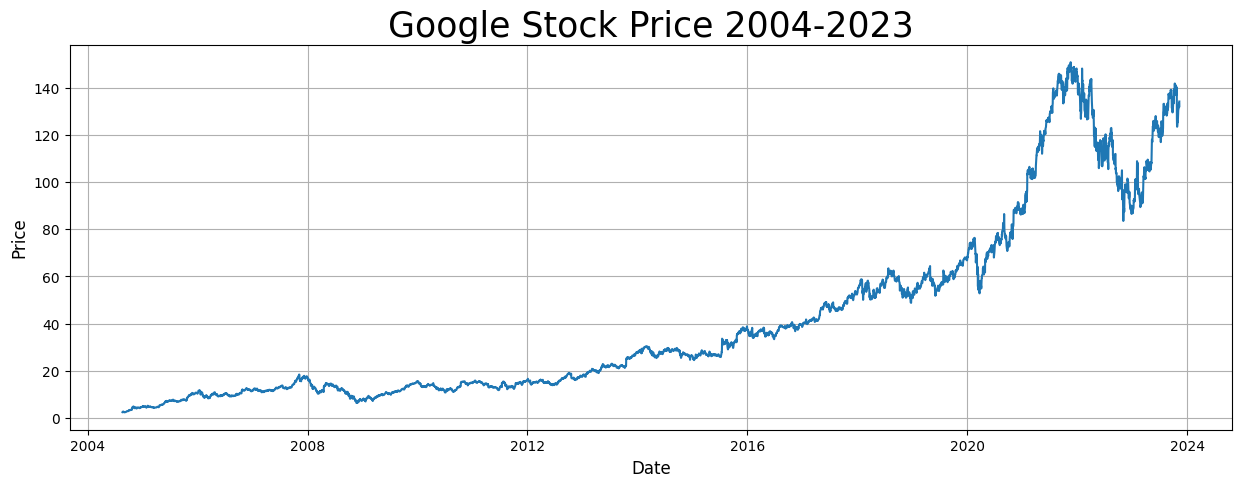

In [5]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'], df['Close'])
plt.xlabel('Date', size = 12)
plt.ylabel('Price', size = 12)
plt.title('Google Stock Price 2004-2023', size = 25)
plt.grid(True)
plt.show()

In [6]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,4842,4842.000000,4842.000000,4842.000000,4842.000000,4842.000000,4.842000e+03
mean,2014-03-31 11:57:01.561338112,41.164402,41.601906,40.745188,41.181457,41.181457,1.192432e+08
min,2004-08-19 00:00:00,2.470490,2.534002,2.390042,2.490913,2.490913,1.584340e+05
25%,2009-06-10 06:00:00,12.819761,12.949089,12.702388,12.828043,12.828043,2.867350e+07
50%,2014-04-01 12:00:00,26.470161,26.668148,26.259000,26.470153,26.470153,6.202500e+07
75%,2019-01-22 18:00:00,57.197751,57.729501,56.633139,57.315001,57.315001,1.469819e+08
max,2023-11-10 00:00:00,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09
std,NaN,38.267895,38.708231,37.871644,38.295204,38.295204,1.513840e+08


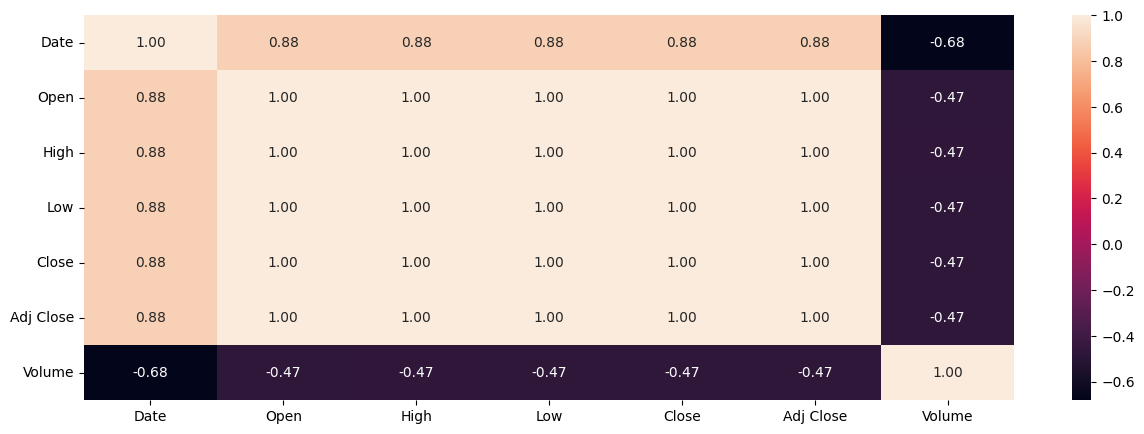

In [7]:
corr_matrix = df.corr()

plt.figure(figsize=(15,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

# Model Creation

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

### Timeseries Cross Validation

In [9]:
tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=12)

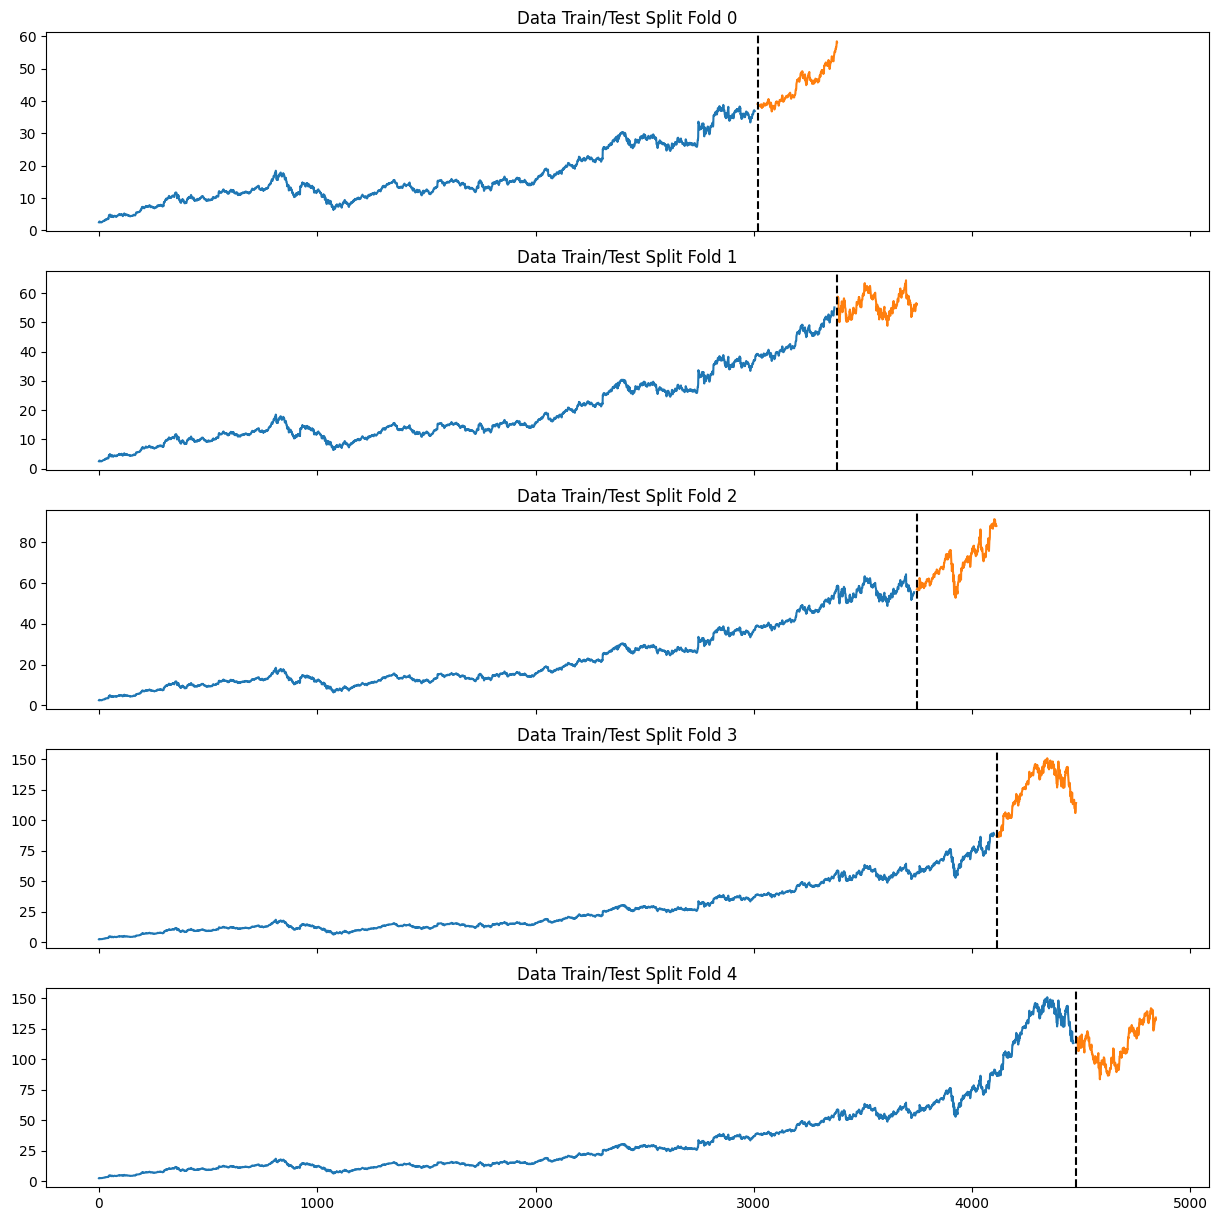

In [10]:
fx, axs = plt.subplots(5, 1, figsize=(15,15),
                       sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Close'].plot(ax=axs[fold], label='Training Set',
                        title=f'Data Train/Test Split Fold {fold}')
    test['Close'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [11]:
reg = xgb.XGBRegressor(n_estimators=1300, learning_rate=0.01,
                       early_stopping_rounds=50, max_depth=3)

fold=0
scores=[]
pred=[]

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    FEATURES = ['High', 'Low', 'Open', 'Volume']
    TARGET = ['Close']

    X_train = train[FEATURES]
    Y_train = train[TARGET]

    x_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train), (x_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(x_test)
    pred.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:8.50823	validation_1-rmse:28.23391
[100]	validation_0-rmse:3.20401	validation_1-rmse:16.22086
[200]	validation_0-rmse:1.22114	validation_1-rmse:11.64581
[300]	validation_0-rmse:0.48332	validation_1-rmse:9.74992
[400]	validation_0-rmse:0.22319	validation_1-rmse:8.90693
[500]	validation_0-rmse:0.14928	validation_1-rmse:8.51349
[600]	validation_0-rmse:0.13324	validation_1-rmse:8.35241
[700]	validation_0-rmse:0.12910	validation_1-rmse:8.26107
[800]	validation_0-rmse:0.12687	validation_1-rmse:8.22061
[900]	validation_0-rmse:0.12552	validation_1-rmse:8.17638
[1000]	validation_0-rmse:0.12451	validation_1-rmse:8.15667
[1100]	validation_0-rmse:0.12353	validation_1-rmse:8.14650
[1200]	validation_0-rmse:0.12250	validation_1-rmse:8.14388
[1299]	validation_0-rmse:0.12164	validation_1-rmse:8.13291
[0]	validation_0-rmse:11.74191	validation_1-rmse:36.35669
[100]	validation_0-rmse:4.41949	validation_1-rmse:17.97211
[200]	validation_0-rmse:1.68515	validation_1-rmse:9.99134
[300]	va

In [12]:
print(f'Average scores = {np.mean(scores):.4f}')

Average scores = 13.3542
